#Projeto 4 – Classificação de lesões de substância branca no Lúpus
---

O objetivo geral do projeto é, a partir de uma classificador treinado em imagens de ressonância do cérebro para diferenciar lesões isquêmicas e desmielinizantes, identificar qual a etiologia mais provável das lesões presentes em pacientes de Lúpus Eritematoso Sistêmico (LES).
    

Para isto, foi escolhido o algoritmo de aprendizado de máquina bastante utilizado em classificação de imagens, Rede Neural Convolucional (ou CNN).

## Apresentação
---

A presente atividade foi originada no contexto das atividades da disciplina de pós-graduação Ciência e Visualização de Dados em Saúde, oferecida no primeiro semestre de 2022, na Unicamp, e desenvolvida pelos alunos:

Nome                           | RA     | Especialização
-------------------------------|--------|------------
Matheus Papa de Almeida        | 183888 | Engenharia Agrícola
Sara Mirthis Dantas dos Santos | 224018 | Aluna Especial - Engenharia Elétrica


##Introdução
---

O Lúpus Eritematoso Sistêmico (SLE) é uma doença inflamatória e autoimune que, diferente do cutâneo, pode acometer vários órgãos do corpo humano. A doença pode causar lesões neurológicas de etiologia isquêmica (similar a lesão de um AVC) ou desmielinizante (similar à Esclerose Múltipla). O objetivo deste trabalho é treinar um modelo de aprendizado de máquina que, a partir de imagens das lesões,  seja capaz de identificar a mais provável etiologia das lesões presentes em pacientes com SLE.

### Ferramentas
---

Neste trabalho, fez-se uso de:
* Imagens de ressonância magnética de lesões isquêmicas e desmielinizantes;
* Modelo de rede neural convolucional (CNN) utilizando a linguagem de programação Python;
  * Rede neural ResNet-18.


Principais bibliotecas utilizadas: 
* Pytorch;
* Numpy;
* Sklearn;
* Matplotlib.


### Preparo e uso dos dados
---

Para o treinamento da CNN, utilizamos as imagens inteiras (sem o uso da máscara) de lesões isquêmicas e desmielinizantes. As transformações realizadas foram o redimensionamento de todas as imagens para 170x170 pixels (totalizando 28900 pixels) e a normalização dos valores de níveis de cinza para números decimais de 0 a 1 (com tipo float64). Como decidimos utilizar um modelo de rede neural, não foi necessário realizar a extração e a seleção de atributos, visto que a própria rede consegue definir esses parâmetros.

##Metodologia

Para que fosse possível a identificação da etiologia da lesão dos pacientes com LES, foi utilizado um dataset com imagens de RM de 50 pacientes com lesões isquêmicas e 51 com lesões desmielinizantes, possuindo um total de 1824 imagens. As imagens foram divididas por paciente de forma aleatória em conjuntos de treino, validação e teste para serem usadas em uma Rede Neural Convolucional (CNN) de arquitetura ResNet18. Desta forma, não existe informação do mesmo paciente em mais de um conjunto. 


Para o treinamento da CNN, utilizamos as imagens inteiras, sem retirada da Região de Interesse (ROI) ou aplicação da máscara da lesão segmentada. As transformações realizadas foram o redimensionamento de todas as imagens para 170x170 pixels e a normalização dos valores de níveis de cinza para números decimais de 0 a 1.
Como foi utilizado um modelo de rede neural, não foi necessário realizar a extração e seleção de atributos, visto que a própria rede consegue definir esses parâmetros a partir da extração de características das imagens. Desta forma, a CNN aprende sozinha quais delas são importantes para realizar a classificação.


Para definir os parâmetros da rede e avaliar sua performance, as métricas de
acurácia e perda (do inglês, *loss*) foram verificados durante o treinamento e teste.

###Pré-processamento

In [ ]:
from __future__ import print_function, division
import os
import copy
import time
import torch
import itertools
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
from glob import glob
from torchsummary import summary
from sklearn.metrics import confusion_matrix

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# connect drive
from google.colab import drive
drive.mount("/content/gdrive")

atv_folder_path = "gdrive/MyDrive/CVDS_P4_imagens/P4/"

img_path = os.path.join(atv_folder_path, "Train")

avc_img_path =  os.path.join(img_path, "AVC")
em_img_path = os.path.join(img_path, "EM")

test_folder_path = os.path.join(atv_folder_path, "SLE")

Mounted at /content/gdrive


In [ ]:
brain_lesion = {"NULL": -1, "AVC": 0, "EM": 1}
brain_lesion_rev = dict(map(reversed, brain_lesion.items()))

A função `check_img_name` verifica o ID do paciente e da flair.

É verificado apenas o valor do ID, não importando a quantidade de zeros a esquerda, por exemplo:


> "001" é igual a "1"

In [ ]:
import re
from pathlib import Path


def check_img_name(img_path: str):
  mask_img_array = list(map(os.path.basename, glob(os.path.join(img_path, "*mask*"))))
  img_list = list(set(os.listdir(img_path))-set(mask_img_array))
  patient_id_list = []
  img_path_list = []
  for img_name in img_list:
    img_name_split = Path(img_name).stem.split("_")
    patient_id = img_name_split[0]
    flair_id = int(img_name_split[-1].split("FLAIR")[-1])
    id_mask_match = list(filter(re.compile("^" + patient_id + "_" + ".*FLAIR" + str(flair_id) + "_mask.").match, mask_img_array))
    if id_mask_match:
      patient_id_list.append(patient_id)
      img_path_list.append(os.path.join(img_path, img_name))
  return list(set(patient_id_list)), img_path_list

In [ ]:
avc_patient_id, avc_img_list = check_img_name(avc_img_path)
em_patient_id, em_img_list = check_img_name(em_img_path)
test_patient_id, test_img_list = check_img_name(test_folder_path)

In [ ]:
print("Quantity of AVC patients:", len(avc_patient_id))
print("Quantity of EM patients:", len(em_patient_id))
print("Quantity of patients in test:", len(test_patient_id))

Quantity of AVC patients: 50
Quantity of EM patients: 51
Quantity of patients in test: 78


Incialmente, agrupamos as imagens por ID do paciente a fim de evitar que imagens do mesmo paciente estejam no dados de treino e teste. Para isso, criamos a função `group_patient_imgs`.

In [ ]:
def group_patient_imgs(img_path_list: list, patient_id_list: list):
  img_grouped = []
  for patient_id in patient_id_list:
    pat_img_grouped = []
    for img_path in img_path_list:
      img_name_split = Path(img_path).stem.split("_")
      img_patient_id = int(img_name_split[0])
      if int(patient_id) == img_patient_id:
        pat_img_grouped.append(img_path)
    img_grouped.append(pat_img_grouped)
  return img_grouped

In [ ]:
x_data_avc = group_patient_imgs(avc_img_list, avc_patient_id)
x_data_em = group_patient_imgs(em_img_list, em_patient_id)
x_data_test = group_patient_imgs(test_img_list, test_patient_id)

y_data_avc = [brain_lesion["AVC"]]*len(avc_patient_id)
y_data_em = [brain_lesion["EM"]]*len(em_patient_id)
y_data_test = [brain_lesion["NULL"]]*len(em_patient_id)

As features foram separadas em variáveis de entrada (``x_data_avc``, ``x_data_em``) e variáveis de saída (``y_data_avc``, ``y_data_em``) e, em seguida, foi destinado 70% do dataset para treino (``x_train_avc`` e ``y_train_avc``, ``x_train_em`` e ``y_train_em``), 15% para validação (``x_val_avc`` e ``y_val_avc``, ``x_val_em`` e ``y_val_em``) e 15% para teste (``x_test_avc`` e ``y_test_avc``, ``x_test_em`` e ``y_test_em``).


Para isto, foi utilizada a função ``train_test_split``, da biblioteca scikit-learn. A fim de obtermos resultados reprodutíveis, o valor do parâmetro ``random_state`` foi fixado em 1000.



In [ ]:
from sklearn.model_selection import train_test_split

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

x_train_avc, x_test_avc, _, _ = train_test_split(x_data_avc, y_data_avc, test_size=1-train_ratio, random_state=1000)
x_val_avc, x_test_avc, _, _ = train_test_split(x_test_avc, _, test_size=test_ratio/(test_ratio + validation_ratio), random_state=1000) 

x_train_em, x_test_em, _, _ = train_test_split(x_data_em, y_data_em, test_size=1-train_ratio, random_state=1000)
x_val_em, x_test_em, _, _ = train_test_split(x_test_em, _, test_size=test_ratio/(test_ratio + validation_ratio), random_state=1000)

x_train_avc = list(itertools.chain(*x_train_avc))
x_val_avc = list(itertools.chain(*x_val_avc))
x_test_avc = list(itertools.chain(*x_test_avc))
y_train_avc = [brain_lesion["AVC"]]*len(x_train_avc)
y_val_avc = [brain_lesion["AVC"]]*len(x_val_avc)
y_test_avc = [brain_lesion["AVC"]]*len(x_test_avc)

x_train_em = list(itertools.chain(*x_train_em))
x_val_em = list(itertools.chain(*x_val_em))
x_test_em = list(itertools.chain(*x_test_em))
y_train_em = [brain_lesion["EM"]]*len(x_train_em)
y_val_em = [brain_lesion["EM"]]*len(x_val_em)
y_test_em = [brain_lesion["EM"]]*len(x_test_em)

In [ ]:
x_final_test = list(itertools.chain(*x_data_test))
y_final_test = [brain_lesion["NULL"]]*len(x_final_test)

Para fins de reprodutibilidade do modelo, os dados de treino, teste e validação serão salvos em na pasta do Google Drive.

In [ ]:
dataset_path = os.path.join(atv_folder_path, "data")
train_path = os.path.join(dataset_path, "train")
train_avc_path = os.path.join(train_path, "AVC")
train_em_path = os.path.join(train_path, "EM")
test_path = os.path.join(dataset_path, "test")
test_avc_path = os.path.join(test_path, "AVC")
test_em_path = os.path.join(test_path, "EM")
validation_path = os.path.join(dataset_path, "validation")
validation_avc_path = os.path.join(validation_path, "AVC")
validation_em_path = os.path.join(validation_path, "EM")

Esse bloco só deve ser executado caso o *split* de dados não tenha sido previamente feito.

In [ ]:
import shutil
from pathlib import Path


def create_folder(new_folder, check=True):
  if check:
    if not os.path.exists(new_folder):
      os.makedirs(new_folder)

create_folder(train_path)
create_folder(train_avc_path)
create_folder(train_em_path)

create_folder(test_path)
create_folder(test_avc_path)
create_folder(test_em_path)

create_folder(validation_path)
create_folder(validation_avc_path)
create_folder(validation_em_path)
    
def save_train_test_val_imgs(final_path, image_list):
  for image in image_list:
    shutil.copy(image, os.path.join(final_path, Path(image).name))

save_train_test_val_imgs(train_avc_path, x_train_avc)
save_train_test_val_imgs(validation_avc_path, x_val_avc)
save_train_test_val_imgs(test_avc_path, x_test_avc)

save_train_test_val_imgs(train_em_path, x_train_em)
save_train_test_val_imgs(validation_em_path, x_val_em)
save_train_test_val_imgs(test_em_path, x_test_em)

As imagens das pastas de treino, validação e teste serão lidas. Como foi feita a separação de dados considerando a identificação dos pacientes, foi necessário unificar os dados de treino e teste de AVC e de EM, ficando com um conjunto final:

> Treino: ``x_train`` e ``y_train``;

> Validação: ``x_val`` e ``y_val``;

> Teste: ``x_test`` e ``y_test``.

In [ ]:
from glob import glob

list_train_avc_path = glob(os.path.join(train_avc_path, "*"))
list_train_em_path = glob(os.path.join(train_em_path, "*"))
list_val_avc_path = glob(os.path.join(validation_avc_path, "*"))
list_val_em_path = glob(os.path.join(validation_em_path, "*"))
list_test_avc_path = glob(os.path.join(test_avc_path, "*"))
list_test_em_path = glob(os.path.join(test_em_path, "*"))

x_train_avc = list_train_avc_path
x_train_em = list_train_em_path
x_val_avc = list_val_avc_path
x_val_em = list_val_em_path
x_test_avc = list_test_avc_path
x_test_em = list_test_em_path

x_train = x_train_avc + x_train_em
x_val = x_val_avc + x_val_em
x_test = x_test_avc + x_test_em

y_train_avc = [brain_lesion["AVC"]]*len(list_train_avc_path)
y_val_avc = [brain_lesion["AVC"]]*len(list_val_avc_path)
y_test_avc = [brain_lesion["AVC"]]*len(list_test_avc_path)
y_train_em = [brain_lesion["EM"]]*len(list_train_em_path)
y_val_em = [brain_lesion["EM"]]*len(list_val_em_path)
y_test_em = [brain_lesion["EM"]]*len(list_test_em_path)

y_train = y_train_avc + y_train_em
y_val = y_val_avc + y_val_em
y_test = y_test_avc + y_test_em

Com o código abaixo visualizamos o número de imagens para cada conjunto definido (treino, validação e teste).

In [ ]:
print("Train images:\n\tX:", len(x_train), "\n\tY:", len(y_train))
print("Validation images: \n\tX:", len(x_val), "\n\tY:", len(y_val))
print("Test images: \n\tX:", len(x_test), "\n\tY:", len(y_test))
print("Final test images: \n\tX:", len(x_final_test), "\n\tY:", len(y_final_test))

Train images:
	X: 1071 
	Y: 1071
Validation images: 
	X: 368 
	Y: 368
Test images: 
	X: 385 
	Y: 385
Final test images: 
	X: 697 
	Y: 697


O código abaixo mostra o número total de imagens de cada divisão realizada (treino, validação e teste) para imagens de lesões isquêmicas (AVC) e desmielinizantes (EM).

In [ ]:
print("Train images - Ischemic:\n\tX:", len(x_train_avc), "\n\tY:", len(y_train_avc))
print("Validation images - Ischemic: \n\tX:", len(x_val_avc), "\n\tY:", len(y_val_avc))
print("Test images - Ischemic: \n\tX:", len(x_test_avc), "\n\tY:", len(y_test_avc))
print("-"*20)
print("Train images - Demyelinating:\n\tX:", len(x_train_em), "\n\tY:", len(y_train_em))
print("Validation images - Demyelinating:\n\tX:", len(x_val_em), "\n\tY:", len(y_val_em))
print("Test images - Demyelinating: \n\tX:", len(x_test_em), "\n\tY:", len(y_test_em))

Train images - Ischemic:
	X: 486 
	Y: 486
Validation images - Ischemic: 
	X: 172 
	Y: 172
Test images - Ischemic: 
	X: 187 
	Y: 187
--------------------
Train images - Demyelinating:
	X: 585 
	Y: 585
Validation images - Demyelinating:
	X: 196 
	Y: 196
Test images - Demyelinating: 
	X: 198 
	Y: 198


A seguir, será selecionada as imagens do conjunto de dados de lesões de pacientes de Lúpus Eritematoso Sistêmico (SLE) com objetivo de testá-las no nosso modelo classificador.

In [ ]:
import cv2
from PIL import Image

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
      self.x = images
      self.y = labels
      self.transform =  torchvision.transforms.Compose([torchvision.transforms.Resize((170,170)),
                                                        torchvision.transforms.ToTensor(),
                                                        torchvision.transforms.Normalize(0, 1)
                                                        ])

    def __getitem__(self, index):
      image_path = self.x[index]
      x = self.transform(Image.open(image_path).convert("RGB"))
      y = int(self.y[index])
      return x, y

    def __len__(self):
      return len(self.x)

In [ ]:
import random 

seed = 3

def seed_worker(worker_id):
    np.random.seed(seed)
    random.seed(seed)

No bloco abaixo os datasets serão criados para que possam servir de entrada no DataLoader.

In [ ]:
train_set = ImageDataset(x_train, y_train)
valid_set = ImageDataset(x_val, y_val)
test_set = ImageDataset(x_test, y_test)

final_test_set = ImageDataset(x_final_test, y_final_test)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, worker_init_fn=seed_worker)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2, worker_init_fn=seed_worker)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, worker_init_fn=seed_worker)

final_test_loader = torch.utils.data.DataLoader(final_test_set, batch_size=batch_size, shuffle=False, num_workers=2, worker_init_fn=seed_worker)

In [ ]:
dataloaders = {"train": train_loader, "validation": valid_loader, "test": test_loader, "final test": final_test_loader}
dataset_sizes = {"train": len(train_loader.dataset), "validation": len(valid_loader.dataset), "test": len(test_loader.dataset), "final test": len(final_test_loader.dataset)}
print(dataloaders)
print(dataset_sizes)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f8fa242f910>, 'validation': <torch.utils.data.dataloader.DataLoader object at 0x7f8fa242f990>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f8fa242fa90>, 'final test': <torch.utils.data.dataloader.DataLoader object at 0x7f8fa242fb50>}
{'train': 1071, 'validation': 368, 'test': 385, 'final test': 697}


A seguir, visualizamos as imagens enviados com as informações de:

* Valor mínimo;
* Mediana;
* Média;
* Valor máximo;
* Desvio padrão.

para cada lote de imagens dos conjuntos definidos anteriormente.



Batch of training data


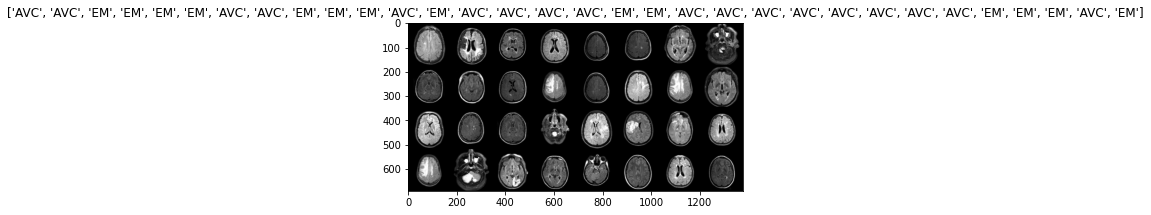

min =  0.0
median =  0.003921569
mean =  0.17295563
max =  0.99607843
std =  0.24635829

Batch of validation data


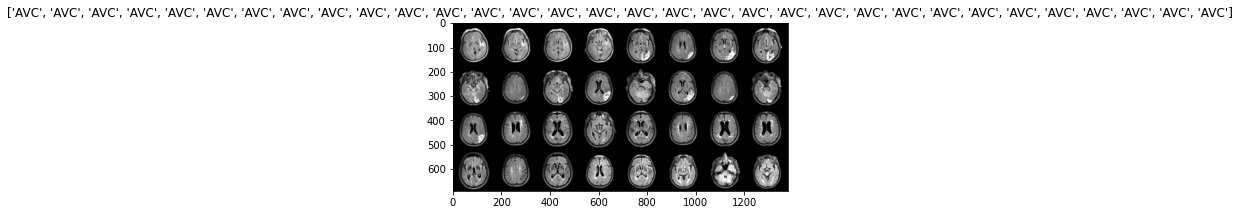

min =  0.0
median =  0.003921569
mean =  0.20346843
max =  0.99607843
std =  0.2621369

Batch of test data


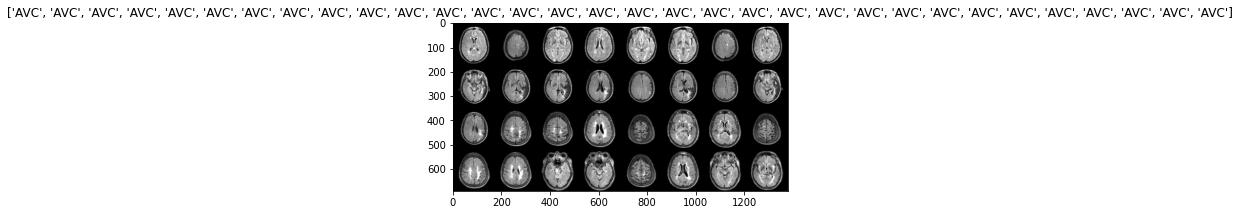

min =  0.0
median =  0.03137255
mean =  0.2281241
max =  0.99607843
std =  0.27588394

Batch of final test data


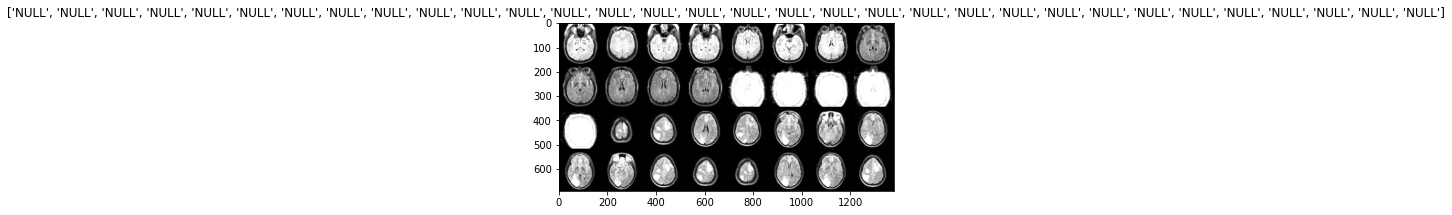

min =  0.0
median =  0.15686275
mean =  0.35650018
max =  1.0
std =  0.38998154


In [ ]:
#visualize
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.ion()   # interactive mode

print("Batch of training data")
inputs, classes = next(iter(train_loader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[brain_lesion_rev[int(x)] for x in classes])
print("min = ", np.min(inputs.numpy()))
print("median = ", np.median(inputs.numpy()))
print("mean = ", np.mean(inputs.numpy()))
print("max = ", np.max(inputs.numpy()))
print("std = ", np.std(inputs.numpy()))


print("\nBatch of validation data")
inputs, classes = next(iter(valid_loader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[brain_lesion_rev[int(x)] for x in classes])
print("min = ", np.min(inputs.numpy()))
print("median = ", np.median(inputs.numpy()))
print("mean = ", np.mean(inputs.numpy()))
print("max = ", np.max(inputs.numpy()))
print("std = ", np.std(inputs.numpy()))


print("\nBatch of test data")
inputs, classes = next(iter(test_loader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[brain_lesion_rev[int(x)] for x in classes])
print("min = ", np.min(inputs.numpy()))
print("median = ", np.median(inputs.numpy()))
print("mean = ", np.mean(inputs.numpy()))
print("max = ", np.max(inputs.numpy()))
print("std = ", np.std(inputs.numpy()))

print("\nBatch of final test data")
inputs, classes = next(iter(final_test_loader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[brain_lesion_rev[int(x)] for x in classes])
print("min = ", np.min(inputs.numpy()))
print("median = ", np.median(inputs.numpy()))
print("mean = ", np.mean(inputs.numpy()))
print("max = ", np.max(inputs.numpy()))
print("std = ", np.std(inputs.numpy()))

### Treino do modelo

A função `train_model` é responsável por realizar o treino da rede neural convolucional (CNN).

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    loss_train = []
    loss_val = []
    acc_train = []
    acc_val = []
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("-" * 10)
        print("Epoch {}/{}".format(epoch, num_epochs - 1))

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == "train":
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == "train":
                epoch_train_loss = epoch_loss
                loss_train.append(epoch_loss)
                acc_train.append(float(epoch_acc))
            if phase == "validation":
                epoch_val_loss = epoch_loss
                loss_val.append(epoch_loss)
                acc_val.append(float(epoch_acc))
    time_elapsed = time.time() - since
    print("\nTraining complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc: {:4f}".format(best_acc))
    print("Best epoch: {}".format(best_epoch))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_train, acc_train, loss_val, acc_val

A função `resnet18_model` é responsável por carregar a rede ResNet18.

In [ ]:
def resnet18_model():
  model = torchvision.models.resnet18(pretrained=False)
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 2)
  model = model.to(device)
  return model

Na função `model_opt` são definidos os parâmetros para a realização do treino da CNN.

In [ ]:
def model_opt(lr: float = 0.001):
    torch.manual_seed(seed)
    # for cuda
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

    model = resnet18_model()

    criterion = nn.CrossEntropyLoss()

    # Parameters optimization
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.1)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
    return model, criterion, optimizer, scheduler

A função `model_info` é utilizada para visualização das seguintes informações do modelo:

* Total de parâmetros;
* Total de parâmetros treináveis;
* Total de parâmetros não treináveis.



In [ ]:
def model_info(model):
    total_params = sum(p.numel() for p in model.parameters())
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - total_trainable_params
    print("Total Parameters: ", total_params)
    print("Total Trainable Parameters: ", total_trainable_params)
    print("Total Non Trainable Parameters: ", non_trainable_params)

No bloco abaixo realizamos o treino da rede com 100 épocas, visualizando a acurácia e a *loss* para treino e validação em cada época.

Os parâmetros do modelo (*learning rate*, *momentum*, *weight decay*, *step size* e *gamma*) foram escolhidos a partir da avaliação dos gráficos de acurácia e *loss*.

In [ ]:
model, criterion, optimizer, scheduler = model_opt(0.006)
model_info(model)
print("\n")
model_train, loss_train, acc_train, loss_val, acc_val = train_model(model, criterion, optimizer, scheduler, num_epochs=100)

Total Parameters:  11177538
Total Trainable Parameters:  11177538
Total Non Trainable Parameters:  0


----------
Epoch 0/99
train Loss: 0.3840 Acc: 0.8161
validation Loss: 1.4637 Acc: 0.4674
----------
Epoch 1/99
train Loss: 0.1900 Acc: 0.9328
validation Loss: 0.4041 Acc: 0.8505
----------
Epoch 2/99
train Loss: 0.1355 Acc: 0.9542
validation Loss: 0.0997 Acc: 0.9783
----------
Epoch 3/99
train Loss: 0.0990 Acc: 0.9757
validation Loss: 0.0853 Acc: 0.9891
----------
Epoch 4/99
train Loss: 0.0892 Acc: 0.9767
validation Loss: 0.0639 Acc: 0.9891
----------
Epoch 5/99
train Loss: 0.0777 Acc: 0.9823
validation Loss: 0.0546 Acc: 0.9891
----------
Epoch 6/99
train Loss: 0.0779 Acc: 0.9813
validation Loss: 0.0626 Acc: 0.9891
----------
Epoch 7/99
train Loss: 0.0720 Acc: 0.9813
validation Loss: 0.0546 Acc: 0.9891
----------
Epoch 8/99
train Loss: 0.0711 Acc: 0.9823
validation Loss: 0.0547 Acc: 0.9891
----------
Epoch 9/99
train Loss: 0.0731 Acc: 0.9785
validation Loss: 0.0555 Acc: 0.9891
-------

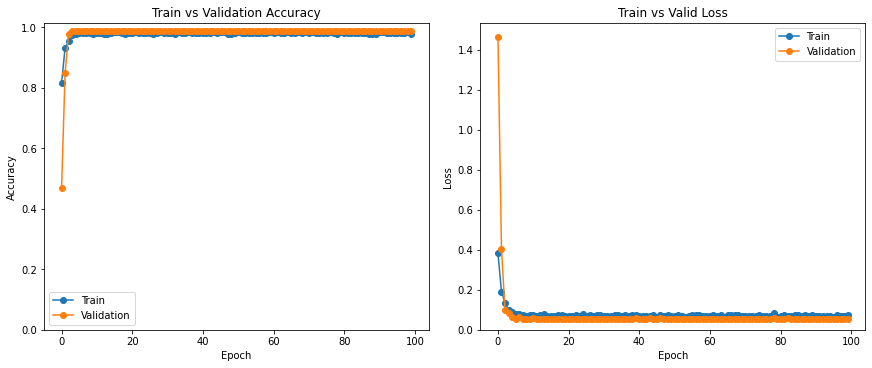

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

ax[0].plot(acc_train,"-o")
ax[0].plot(acc_val,"-o")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend(["Train","Validation"])
ax[0].set_title("Train vs Validation Accuracy")
ax[0].set_ylim(bottom=0)

ax[1].plot(loss_train,"-o")
ax[1].plot(loss_val,"-o")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend(["Train","Validation"])
ax[1].set_title("Train vs Valid Loss")
ax[1].set_ylim(bottom=0)
plt.show()

Como o modelo alcançou estabilidade de *loss* e acurácia com poucas épocas, escolhemos retreinar o mesmo modelo com 20 épocas.

In [ ]:
final_epoch = 20
model, criterion, optimizer, scheduler = model_opt(0.006)
model_final, loss_train, acc_train, loss_val, acc_val = train_model(model, criterion, optimizer, scheduler, num_epochs=final_epoch)

----------
Epoch 0/19
train Loss: 0.3840 Acc: 0.8161
validation Loss: 1.4637 Acc: 0.4674
----------
Epoch 1/19
train Loss: 0.1900 Acc: 0.9328
validation Loss: 0.4041 Acc: 0.8505
----------
Epoch 2/19
train Loss: 0.1355 Acc: 0.9542
validation Loss: 0.0997 Acc: 0.9783
----------
Epoch 3/19
train Loss: 0.0990 Acc: 0.9757
validation Loss: 0.0853 Acc: 0.9891
----------
Epoch 4/19
train Loss: 0.0892 Acc: 0.9767
validation Loss: 0.0639 Acc: 0.9891
----------
Epoch 5/19
train Loss: 0.0777 Acc: 0.9823
validation Loss: 0.0546 Acc: 0.9891
----------
Epoch 6/19
train Loss: 0.0779 Acc: 0.9813
validation Loss: 0.0626 Acc: 0.9891
----------
Epoch 7/19
train Loss: 0.0720 Acc: 0.9813
validation Loss: 0.0546 Acc: 0.9891
----------
Epoch 8/19
train Loss: 0.0711 Acc: 0.9823
validation Loss: 0.0547 Acc: 0.9891
----------
Epoch 9/19
train Loss: 0.0731 Acc: 0.9785
validation Loss: 0.0555 Acc: 0.9891
----------
Epoch 10/19
train Loss: 0.0738 Acc: 0.9823
validation Loss: 0.0576 Acc: 0.9891
----------
Epoch 11/

A seguir visualizamos o gráfico com os valores de acurácia e *loss* para a quantidade de épocas final escolhida para treino e validação.

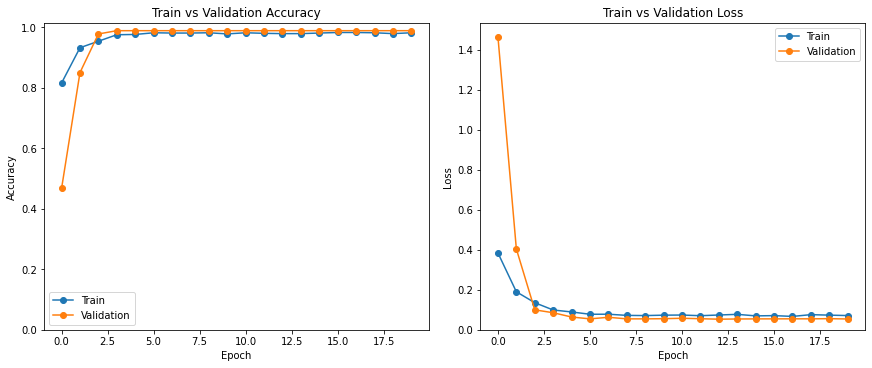

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

ax[0].plot(acc_train,"-o")
ax[0].plot(acc_val,"-o")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend(["Train","Validation"])
ax[0].set_title("Train vs Validation Accuracy")
ax[0].set_ylim(bottom=0)

ax[1].plot(loss_train,"-o")
ax[1].plot(loss_val,"-o")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend(["Train","Validation"])
ax[1].set_title("Train vs Validation Loss")
ax[1].set_ylim(bottom=0)
plt.show()

Após treinar o modelo, ele será salvo na pasta do Google Drive.

In [ ]:
model_path = os.path.join(atv_folder_path, "resnet18_neuroimages_model.pt")

In [ ]:
torch.save(model_final.state_dict(), model_path)

Para que possa ser usado em predições, iremos carregar o modelo previamente salvo.

In [ ]:
model_saved = resnet18_model()
model_saved.load_state_dict(torch.load(model_path))
model_saved.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

A função `predict_model` recebe as imagens de teste a fim de classificá-las.

In [ ]:
def predict_model(model, dataloader, num_images, plot_img=False):
    was_training = model.training
    model.eval()
    images_so_far = 0
    predicted = []
    label = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
              images_so_far += 1
              curr_label = int(labels[j])
              curr_pred = int(preds[j])
              predicted.append(brain_lesion_rev[curr_pred])
              label.append(brain_lesion_rev[curr_label])
              if plot_img:
                plt.figure()
                plt.imshow(inputs.cpu().data[j].numpy().transpose((1, 2, 0)))
                plt.axis("off")
                plt.title("predicted: {} - label: {}".format(brain_lesion_rev[curr_pred], brain_lesion_rev[curr_label]))
                plt.plot()

              if images_so_far == num_images:
                model.train(mode=was_training)
                # break
                return predicted, label
        model.train(mode=was_training)
    return predicted, label

No bloco abaixo realizamos a predição das imagens do conjunto de teste.

In [ ]:
num_images_test = dataset_sizes["test"]
predicted_test, label_test = predict_model(model_saved, dataloaders["test"], num_images_test, plot_img=False)

Com o código abaixo visualizamos as predições realizadas pelo modelo, avaliando a matriz de confusão, sensibilidade, especificidade e acurária geral. Os dados demonstraram que:

* A sensibilidade (quantidade de imagens preditas como "EM" / total de imagens "EM") do modelo atingiu 95%;
* A especificidade (quantidade de imagens preditas como "AVC" / total de imagens "AVC") atingiu 100%;
* A acurácia geral atingiu 97%.


In [ ]:
test_AVC_size = len([x for x in range(len(label_test)) if label_test[x] == "AVC"])
test_EM_size = len([x for x in range(len(label_test)) if label_test[x] == "EM"])

print("\nConjunto de Teste\n")
CM_test = confusion_matrix(label_test, predicted_test)
Sensibilidade = CM_test[1,1]/test_EM_size
Especificidade = CM_test[0,0]/test_AVC_size
print("labels = ", label_test)
print("predições = ", predicted_test)
print("matriz de confusão = \n", CM_test)
print("Sensibilidade = ", Sensibilidade)
print("Especificidade = ", Especificidade)
print("acc = ", len([x for x in range(len(label_test)) if label_test[x] == predicted_test[x]])/num_images_test)


Conjunto de Teste

labels =  ['AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AV

## Resultados e Discussão


---



### Predição do conjunto de teste
---

No bloco abaixo realizamos a predição das imagens de pacientes com Lúpus Eritematoso Sistêmico (SLE).

In [ ]:
num_images_final_test = dataset_sizes["final test"]
predicted_final_test, label_final_test = predict_model(model_saved, dataloaders["final test"], num_images_final_test, plot_img=False)

Com os blocos abaixo, fazemos a definição da etiologia para a cada paciente com SLE. Tendo em vista que o dataset fornecido contém mais de uma imagem por paciente, realizamos a predição para cada uma das imagens e, posteriormente, utilizamos a média dos *labels* das imagens por paciente seguindo as seguinte regras:

* Caso a maior parte das imagens do paciente sejam classificadas como lesão isquêmica, iremos considerar que o paciente possui uma lesão de etiologia isquêmica; 
* Caso a maior parte das imagens do paciente sejam classificadas como lesão desmielinizante, iremos considerar que o paciente possui uma lesão de etiologia desmielinizante;
* Caso o número de imagens com lesões isquêmicas e desmielinizantes seja igual para o paciente, consideraremos que não foi possível classificar a sua lesão.



In [ ]:
images_classified = []
for i, img in enumerate(x_final_test):
  images_classified.append([x_final_test[i], predicted_final_test[i]])

patient_classified = []
for i, item in enumerate(test_patient_id):
  patient_id = int(item)
  avc_count = 0
  em_count = 0
  for img in images_classified:
    img_name_split = Path(img[0]).stem.split("_")
    img_patient_id = int(img_name_split[0])
    if (patient_id == img_patient_id):
      if (img[1] == "AVC"):
        avc_count = avc_count + 1
      else:
        em_count = em_count + 1
  label = "NULL" 
  if (avc_count > em_count):
    label = "AVC"
  elif (avc_count < em_count):
    label = "EM"
  patient_classified.append([patient_id, label])

In [ ]:
df_patient_classified = pd.DataFrame(patient_classified, columns=["PATIENT", "LABEL"])
labels = df_patient_classified["LABEL"].value_counts()

Após a definição das lesões por pacientes, obtivemos os seguintes resultados:

* 71 pacientes com lesões de etiologia isquêmica;
* 6 pacientes com lesões de etiologia desmielinizante;
* 1 paciente com lesão não classificada.



In [ ]:
num_avc = predicted_final_test.count("AVC")
num_em = predicted_final_test.count("EM")

print("Image Classification:\n")
print("Patients classified with ischemic etiology lesion: ", labels.AVC)
print("Patients classified with demyelinating etiology lesion: ", labels.EM)
print("Patients with lesions unclassifieds: ", labels.NULL)

Image Classification:

Patients classified with ischemic etiology lesion:  71
Patients classified with demyelinating etiology lesion:  6
Patients with lesions unclassifieds:  1


No bloco abaixo plotamos um gráfico com o resultado da classificação das lesões por paciente.

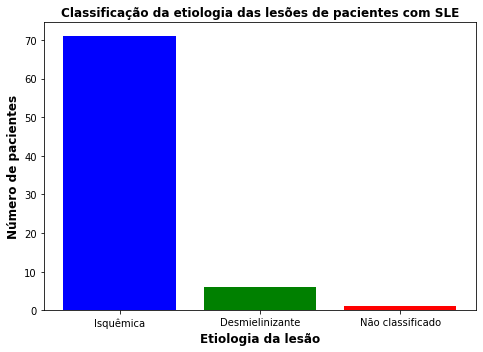

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ["Isquêmica", "Desmielinizante", "Não classificado"]
ax.bar(langs, labels, color=['b', 'g', 'r'])
plt.title("Classificação da etiologia das lesões de pacientes com SLE", fontsize=12, fontweight="bold")
plt.ylabel('Número de pacientes', fontsize=12, fontweight="bold")
plt.xlabel('Etiologia da lesão', fontsize=12, fontweight="bold")
plt.show()

Nos blocos abaixo definimos a função `get_random_numbers`, que retorna cinco valores aleatórios para uma lista de imagens.



In [ ]:
avc_images = [image for i, image in enumerate(x_final_test) if predicted_final_test[i] == "AVC"] 
em_images = [image for i, image in enumerate(x_final_test) if predicted_final_test[i] == "EM"] 

In [ ]:
import random

def get_random_numbers(size):
    random.seed(300)
    x = [random.randint(0,size-1) for i in range(0,5)]
    return x

Com os códigos abaixo extraímos as seguintes estatísticas das imagens de lesões classificadas como isquêmicas e desmielinizantes:
* Contraste;
* Dissimilaridade;
* Homogeneidade;
* ASM;
* Energia;
* Correlação;
* Ênfase de Corrida Curta (Short Run Emphasis - SRE);
* Ênfase de Corrida Longa (Long Run Emphasis - LRE);
* Uniformidade do Nível de Cinza (Grey Level Uniformity - GLU);
* Uniformidade do comprimento da corrida (Run Length Uniformity - RLU);
* Porcentagem de corrida (Run Percentage).

In [ ]:
def get_image(img_path: str, color_flag=0, gray=True):
  image = Image.open(img_path).convert("RGB")
  img = np.array(image)
  if (gray):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

In [ ]:
!pip install tabulate
from tabulate import tabulate
!pip install glrlm
from glrlm import GLRLM
from skimage.feature import greycomatrix, greycoprops

def statistics_RLM(img: np.array):
  img_copy = img.copy();
  app = GLRLM()
  glrlm = app.get_features(img_copy, 8)
  return glrlm

def img_info(images1, images2):
  statistics_array = [["Contrast",
                       "Dissimilarity",
                       "Homogeneity",
                       "ASM",
                       "Energy",
                       "Correlation",
                       "Short Run Emphasis",
                       "Long Run Emphasis",
                       "Grey Level Uniformity",
                       "Run Length Uniformity",
                       "Run Percentage"]]
  val1 = get_random_numbers(len(images1))
  val2 = get_random_numbers(len(images2))
  for i in range(0, 5):
    image = get_image(images1[val1[i]])
    img = image.copy()
    if (len(img.shape) > 2):
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    glcm = greycomatrix(img, distances=[5], angles=[0], levels=256,
                      symmetric=True, normed=True)
    glrlm = statistics_RLM(img)
    statistics_array.append([greycoprops(glcm, prop="contrast")[0],
                            greycoprops(glcm, prop="dissimilarity")[0],
                            greycoprops(glcm, prop="homogeneity")[0],
                            greycoprops(glcm, prop="ASM")[0],
                            greycoprops(glcm, prop="energy")[0],
                            greycoprops(glcm, prop="correlation")[0],
                            glrlm.Features[0],
                            glrlm.Features[1],
                            glrlm.Features[2],
                            glrlm.Features[3],
                            glrlm.Features[4]])
    
  print("Ischemic lesion images")
  print(tabulate(statistics_array, headers="firstrow", tablefmt="fancy_grid", showindex=range(1, 6)))
  statistics_array = [["Contrast",
                       "Dissimilarity",
                       "Homogeneity",
                       "ASM",
                       "Energy",
                       "Correlation",
                       "Short Run Emphasis",
                       "Long Run Emphasis",
                       "Grey Level Uniformity",
                       "Run Length Uniformity",
                       "Run Percentage"]]
  for i in range(0, 5):
    image = get_image(images2[val2[i]])
    img = image.copy()
    if (len(img.shape) > 2):
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    glcm = greycomatrix(img, distances=[5], angles=[0], levels=256,
                      symmetric=True, normed=True)
    glrlm = statistics_RLM(img)
    statistics_array.append([greycoprops(glcm, prop="contrast")[0],
                            greycoprops(glcm, prop="dissimilarity")[0],
                            greycoprops(glcm, prop="homogeneity")[0],
                            greycoprops(glcm, prop="ASM")[0],
                            greycoprops(glcm, prop="energy")[0],
                            greycoprops(glcm, prop="correlation")[0],
                            glrlm.Features[0],
                            glrlm.Features[1],
                            glrlm.Features[2],
                            glrlm.Features[3],
                            glrlm.Features[4]])

  print("Demyelinating lesions images")
  print(tabulate(statistics_array, headers="firstrow", tablefmt="fancy_grid", showindex=range(1, 6)))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


No código abaixo visualizamos as estatísticas para cinco imagens de cada classe (isquêmica e desmielinizante). Comparando os valores podemos notar que as estatísticas extraídas não são suficientes para diferenciar as imagens das duas classes, portanto, a rede neural provavelmente não utilizou esses valores para a classificação das imagens.

In [ ]:
img_info(avc_images, em_images)

Ischemic lesion images
╒════╤════════════╤═════════════════╤═══════════════╤═══════════╤══════════╤═══════════════╤══════════════════════╤═════════════════════╤═════════════════════════╤═════════════════════════╤══════════════════╕
│    │   Contrast │   Dissimilarity │   Homogeneity │       ASM │   Energy │   Correlation │   Short Run Emphasis │   Long Run Emphasis │   Grey Level Uniformity │   Run Length Uniformity │   Run Percentage │
╞════╪════════════╪═════════════════╪═══════════════╪═══════════╪══════════╪═══════════════╪══════════════════════╪═════════════════════╪═════════════════════════╪═════════════════════════╪══════════════════╡
│  1 │   1337.59  │         19.8228 │      0.279516 │ 0.0391777 │ 0.197934 │      0.867057 │                1.449 │             1333.54 │                 3596.02 │                 22487.7 │           38.338 │
├────┼────────────┼─────────────────┼───────────────┼───────────┼──────────┼───────────────┼──────────────────────┼─────────────────────┼────

O código abaixo cria a função `plot_imgs`, que plota cinco imagens aleatórias de lesões classificadas como isquêmicas e desmielinizantes.

In [ ]:
def plot_imgs(images1, images2, vmin_value: float = None, vmax_value: float = None):
  fig, ax = plt.subplots(2, 5, figsize=(30, 10))
  val1 = get_random_numbers(len(images1))
  val2 = get_random_numbers(len(images2))
  for i in range(0, 5):
    image = get_image(images1[i])
    ax[0, i].set_title("Isquêmica")
    ax[0, i].grid(False)
    if not vmax_value:
      vmax_value = np.max(image)
    if not vmin_value:
      vmin_value = np.min(image)
    img = ax[0, i].imshow(image, cmap="gray", vmin=vmin_value, vmax=vmax_value)
    fig.colorbar(img, ax=ax[0, i])
    
  for i in range(0, 5):
    image = get_image(images2[i])
    ax[1, i].set_title("Desmielinizante")
    ax[1, i].grid(False)
    if not vmax_value:
      vmax_value = np.max(image)
    if not vmin_value:
      vmin_value = np.min(image)
    img = ax[1, i].imshow(image, cmap="gray", vmin=vmin_value, vmax=vmax_value)
    fig.colorbar(img, ax=ax[1, i])

Utilizando a função definida anteriormente, visualizamos as imagens classificadas. Essas imagens indicam que, as classificadas como desmielinizantes apresentam maior brilho quando comparadas com as imagens classificadas como isquêmicas. Isso pode indicar que a CNN utilizou esse dado para diferenciar e classificar.


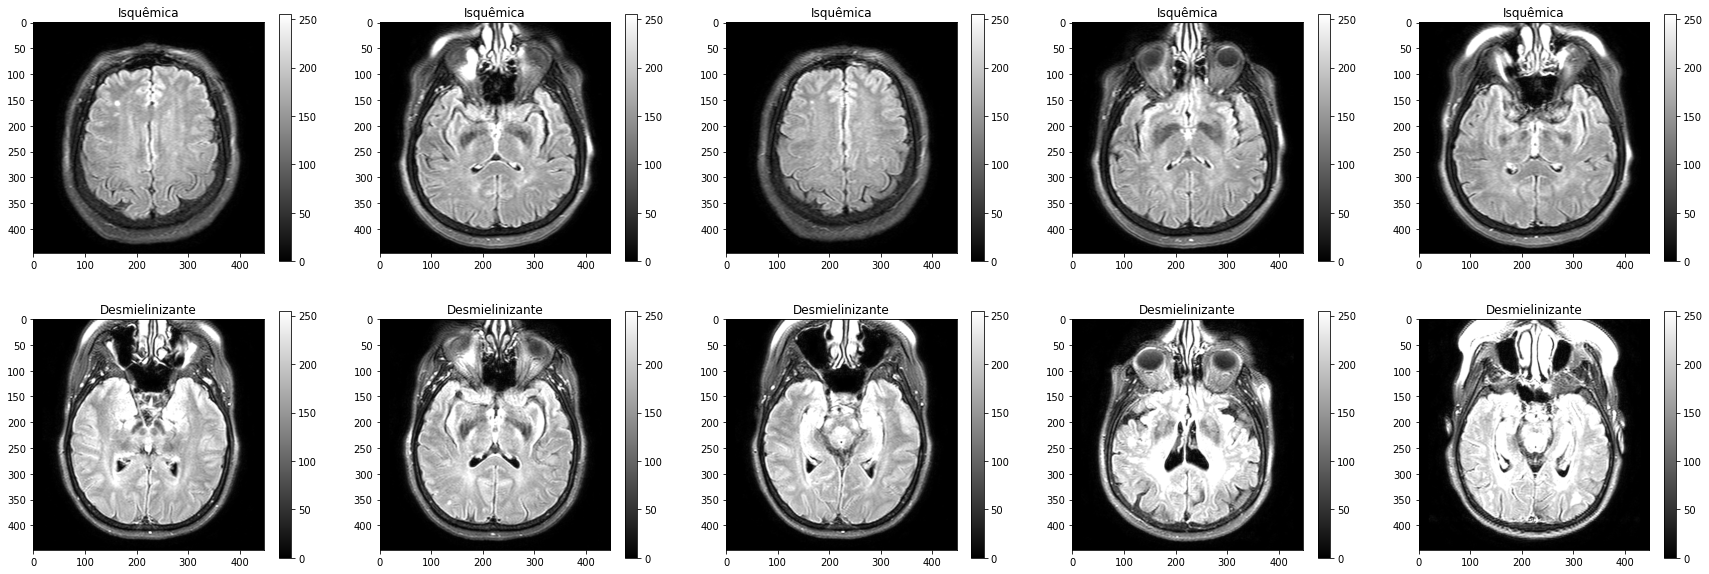

In [ ]:
plot_imgs(avc_images, em_images)

In [ ]:
def normalize_mask(mask_array: np.array):
  mask_min = np.min(mask_array)
  mask_norma = np.where(mask_array > mask_min, 1, 0)
  mask = np.uint8(mask_norma)
  return mask

In [ ]:
def find_mask(img_name: str, mask_list: list):
  for id, mask_name in enumerate(mask_list):
    mask_name_split = mask_name.split("_mask")[0]
    if(mask_name_split == img_name):
      return mask_list[id]

In [ ]:
mask_img_array = list(map(os.path.basename, glob(os.path.join(test_folder_path, "*mask*"))))

Nos blocos abaixo definimos as funções:
> `get_centroid`: usada para registrar a média dos centroides das lesões, através de suas respectivas máscaras;

> `plot_centroids`: usada para plotar os centroides das imagens, baseadas em suas máscaras.






In [ ]:
def get_image_cv2(img_path: str, color_flag=0):
  img_array = cv2.imread(img_path, color_flag)
  return img_array
  
def get_centroid(mask_list: list, img_list: list):
  mean_centroid = []
  x_mean_values = []
  y_mean_values = []
  for id, path in enumerate(img_list):
    basename = os.path.basename(path)
    name = os.path.splitext(basename)[0]
    mask_name = find_mask(name, mask_list)
    mask_path = os.path.join(test_folder_path, mask_name)
    mask = get_image_cv2(mask_path, -1)
    mask_norm = normalize_mask(mask)
    
    cnts = cv2.findContours(mask_norm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  
    x_values = []
    y_values = []
    for i in cnts:
      M = cv2.moments(i)
      if M['m00'] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
      x_values.append(cx)
      y_values.append(cy)
    
    if (len(cnts) > 0):
      x_mean_values.append(np.mean(x_values))
      y_mean_values.append(np.mean(y_values))

  mean_centroid.append([np.mean(x_mean_values), np.mean(y_mean_values)])
  return mean_centroid

In [ ]:
def plot_centroids(images1, images2, mask_list, vmin_value: float = None, vmax_value: float = None):
  fig, ax = plt.subplots(2, 5, figsize=(30, 10))
  val1 = get_random_numbers(len(images1))
  val2 = get_random_numbers(len(images2))
  for i in range(0, 5):
    image = get_image(images1[i], gray=False)
    ax[0, i].set_title("Isquêmica")
    ax[0, i].grid(False)
    if not vmax_value:
      vmax_value = np.max(image)
    if not vmin_value:
      vmin_value = np.min(image)
    
    img_copy = image.copy()
    basename = os.path.basename(images1[i])
    name = os.path.splitext(basename)[0]
    mask_name = find_mask(name, mask_list)
    mask_path = os.path.join(test_folder_path, mask_name)
    mask = get_image_cv2(mask_path, -1)
    mask_norm = normalize_mask(mask)
    
    cnts = cv2.findContours(mask_norm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    x_values = []
    y_values = []
    for j in cnts:
      M = cv2.moments(j)
      if M['m00'] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        # cv2.drawContours(img_copy, [j], -1, (0, 255, 0), 2)
        cv2.circle(img_copy, (cx, cy), 7, (50, 50, 255), -1)
        cv2.putText(img_copy, "center", (cx - 20, cy - 20),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (50, 50, 255), 2)

    img = ax[0, i].imshow(img_copy, cmap="gray", vmin=vmin_value, vmax=vmax_value)
    fig.colorbar(img, ax=ax[0, i])
    
  for i in range(0, 5):
    image = get_image(images2[i], gray=False)
    ax[1, i].set_title("Desmielinizante")
    ax[1, i].grid(False)
    if not vmax_value:
      vmax_value = np.max(image)
    if not vmin_value:
      vmin_value = np.min(image)

    img_copy = image.copy()
    basename = os.path.basename(images2[i])
    name = os.path.splitext(basename)[0]
    mask_name = find_mask(name, mask_list)
    mask_path = os.path.join(test_folder_path, mask_name)
    mask = get_image_cv2(mask_path, -1)
    mask_norm = normalize_mask(mask)
    
    cnts = cv2.findContours(mask_norm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  
    x_values = []
    y_values = []
    for j in cnts:
      M = cv2.moments(j)
      if M['m00'] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        # cv2.drawContours(img_copy, [j], -1, (0, 255, 0), 2)
        cv2.circle(img_copy, (cx, cy), 7, (50, 50, 255), -1)
        cv2.putText(img_copy, "center", (cx - 20, cy - 20),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (50, 50, 255), 2)

    img = ax[1, i].imshow(img_copy, cmap="gray", vmin=vmin_value, vmax=vmax_value)
    fig.colorbar(img, ax=ax[1, i])

No bloco abaixo visualizamos os centroides de partes da lesão baseados na máscara de cada imagem.

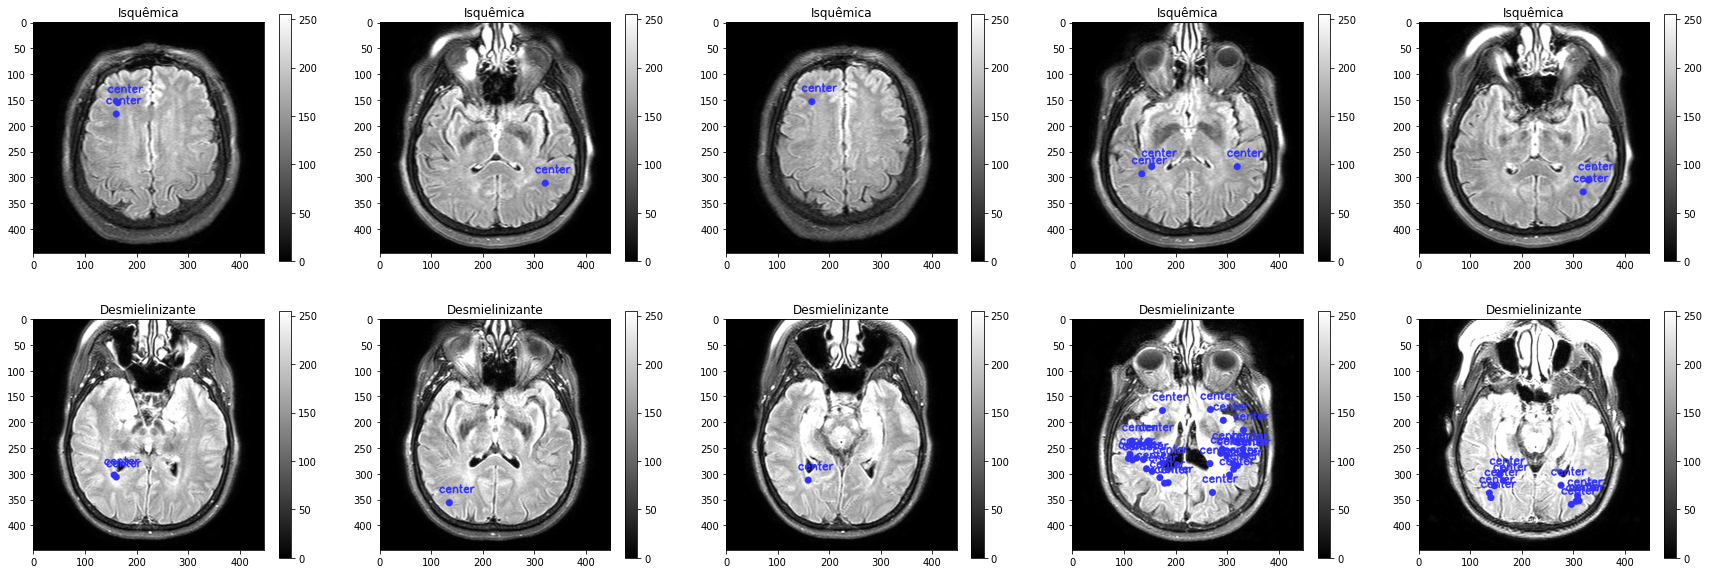

In [ ]:
plot_centroids(avc_images, em_images, mask_img_array)

Nos blocos abaixo, visualizamos as médias das coordenadas dos centroides das lesões classificadas como isquêmicas e desmielinizantes. Observando as médias, concluímos que a posição das lesões são muito próximas entre as classes, não sendo um informação importante para diferenciação e classificação.  

In [ ]:
avc_centroid = get_centroid(mask_img_array, avc_images)

print("Centroid's mean of ischemic lesion images:\n")
print("X axis: ", avc_centroid[0][0])
print("Y axis: ", avc_centroid[0][1])

Centroid's mean of ischemic lesion images:

X axis:  220.83276447225967
Y axis:  227.70772273501564


In [ ]:
em_centroid = get_centroid(mask_img_array, em_images)

print("Centroid's mean of demyelinating lesion images:\n")
print("X axis: ", em_centroid[0][0])
print("Y axis: ", em_centroid[0][1])

Centroid's mean of demyelinating lesion images:

X axis:  219.93327535660097
Y axis:  268.1271592631513


Utilizando uma das imagens, plotamos os valores das médias dos centroides. Dessa forma, podemos observar que as lesões para ambas as classes se distribuem nos dois lados do cérebro, tendo em vista que a média dos valores está muito próxima do centro da imagem.  Além disso, não há muita diferença entre as localizações das lesões de diferentes etiologias, demonstrando que essa informação pode não ser importante para diferenciar lesões isquêmicas e desmielinizantes.


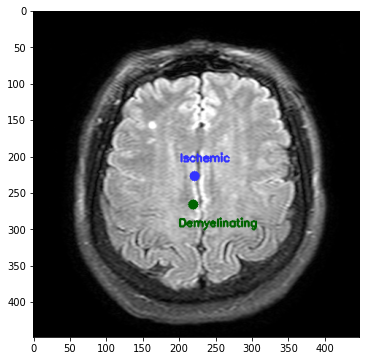

In [ ]:
img = get_image(avc_images[0], gray=False)
img_copy = img.copy()

cv2.circle(img_copy, (int(avc_centroid[0][0]), int(avc_centroid[0][1])), 7, (50, 50, 255), -1)
cv2.putText(img_copy, "Ischemic", (int(avc_centroid[0][0]) - 20, int(avc_centroid[0][1]) - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (50, 50, 255), 2)
cv2.circle(img_copy, (int(em_centroid[0][0]), int(em_centroid[0][1])), 7, (0, 100, 0), -1)
cv2.putText(img_copy, "Demyelinating", (int(em_centroid[0][0]) - 20, int(em_centroid[0][1]) + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 100, 0), 2)

plt.figure(figsize = (20,6))
plt.imshow(img_copy, cmap="gray");

## Conclusão


---



Levando em consideração o estudo das classificações previamente discutidas, temos que o modelo de rede neural convolucional treinado obteve um resultado satisfatório quando testado com imagens de lesões isquêmicas e desmielinizantes. A predição da etiologia das lesões de pacientes com LES demonstrou que a maior parte das lesões são de etiologia isquêmica, representando 91\% dos 78 pacientes analisados, 7,7\% foram classificados com lesões desmielinizantes e 1,3\% não tiveram lesão classificada.

Com o uso da CNN, não foi necessário realizar a extração de atributos para as imagens a serem classificadas, pois a própria rede seleciona os atributos mais importantes para a classificação, porém as informações utilizadas para classificação não são acessíveis, por isso, decidimos avaliar algumas métricas e informações que provavelmente seriam relevantes para diferenciar a etiologia das lesões.

Analisando as imagens classificadas, percebemos que há uma diferença de brilho nas imagens de lesões isquêmicas e desmielinizantes, e a rede neural pode ter utilizado essa informação para a classificação. O maior problema dessa diferença de brilho é que ele pode ter sido causado pela aquisição das imagens por diferentes equipamentos de RM, e a CNN aplicada nessa base de dados pode não ter um bom resultado caso ela seja aplicada para imagens adquiridas por outros equipamentos.

As estatísticas e informações de textura extraídas das imagens (como GLCM e GLRLM) mostraram-se indiferentes e irrelevantes para a diferenciação das imagens classificadas. O estudo das posições das lesões indicou que as lesões de ambas etiologias estudadas distribuem-se de maneira uniforme nos lados direito e esquerdo do cérebro. Houve uma diferença na localização média das lesões desmielinizantes, que apresentaram-se numa posição inferior a média das lesões isquêmicas, porém, tal diferença foi muito sutil, impossibilitando que essa informação seja útil para diferenciar as etiologias.



### Trabalhos futuros


---



Com mais tempo para a execução do trabalho, teríamos analisado o mapa de calor das imagens classificadas como isquêmicas e desmielinizantes, a fim de visualizar qual parte foi mais importante para a classificação de cada imagem.

Apesar da obtenção de bons resultados, com acurácia acima de 97%, gostaríamos de treinar o modelo utilizando mais imagens, provindas de *datasets* públicos. Pois, treinando o modelo com imagens feitas em diversos equipamentos de ressonância magnética, teríamos um modelo mais genérico.

Além disso, poderia ser feito um ajuste fino nos parâmetros do modelo, como *learning rate*, *momentum* e *weight decay*. Notamos que eles possuem uma grande influência no resultado do treino do modelo, de forma que um valor otimizado melhoraria a classificação.

## Referências bibliográficas


---



ABREU, M. R. d. Alterações na ressonância magnética cerebral nos pacientes com lúpus neuropsiquiátrico. Dissertação (Mestrado) — Universidade Federal do Rio Grande do Sul. Faculdade de Medicina. Programa de Pós-Graduação em Medicina: Clínica Médica, 2001.
Disponível em: <https://lume.ufrgs.br/handle/10183/7237>.

APPENZELLER, S. et al. Quantitative magnetic resonance imaging analyses and clinical significance of hyperintense white matter lesions in systemic lupus erythematosus patients. Annals of neurology, v. 64, p. 635–43, 12 2008.

MAIDHOF, W.; HILAS, O. Lupus: An overview of the disease and management options.
P T : a peer-reviewed journal for formulary management, v. 37, p. 240–9, 04/2012.
